## Define LLM

In [7]:
import os
from langchain.chat_models import init_chat_model
from getpass import getpass

In [8]:
os.environ["OPENAI_API_KEY"] = getpass("Enter your OpenAI API key: ")

In [9]:
llm = init_chat_model("openai:gpt-3.5-turbo")

## Define the graph 

In [10]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

## Define the tools

In [11]:
os.environ["TAVILY_API_KEY"] = getpass("Enter yout Tavily API key: ")

In [12]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=2)
tools = [tool]
#tool.invoke("What is the capital of France?")

## Continue Define the graph

In [13]:
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

## Create a function to run the tools

Buat node func baru bernama BasicToolNode yang berfungsi untuk check most recent message di dalam state dan memanggil tools jika AIMessage mengandung tool_calls

In [14]:
import json 

from langchain_core.messages import ToolMessage

class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage"""
    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}
    
    def __call__(self, inputs: dict):
        if messages := inputs.get("message", []):
            message = messages[-1]
        else: 
            raise ValueError("No message found in input")
        
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(tool_call["arguments"])
            outputs.append(
                ToolMessage(
                    content = json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"]
                )
            )
        return {"messages": outputs}

In [15]:
tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

Variabel tool_node sekarang menyimpan instance dari BasicToolNode yang telah dikonfigurasi dengan TavilySearch tool.

## Define conditional_edges

Conditional Edges?? Jadi Edges itu route the control flow dari satu node ke next node, nah klo Conditional Edges itu bermulai dari 1 node dan biasanya terdapat if-statements untuk route to different nodes tergantung current graph state. Func ini menerima current graph state dan me-return string atau list of strings yang mengindikasikan kemana node berikutnya

Oke jadi, buat router func dengan nama route_tools yang menge-check untuk tool_calls ada atau tidak di chatbot's output. Provide this func to graph dengan call add_conditional_edges, yang memberi tahu graph setiap chatbot node selesai untuk check kemana tujuan berikutnya

The condition will route to tools ketika tools_calls ada dan END ketika tidak ada. 

In [ ]:
def route_tools(state: State):
    """
    Use in the conditional_edge to route to the ToolNode if the last message has tool calls. Otherwise, route to the END
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else: 
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools" #return ke tools node
    return END

In [17]:
# tools_condition func return "tools ketika chatbot asks to use tool, dan "END" ketika tidak apa melakukan direct response
# this conditional routing defines the main agent loop

graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    {
        "tools": "tools",
        END: END,
    }
)

# Setiap tool dipanggil, kita return ke chatbot untuk decide next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

graph = graph_builder.compile()

# Visualize the graph

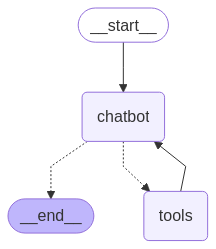

In [18]:
from IPython.display import display, Image

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

## Better Use Prebuilt if already understand the low level

- 'BasicToolNode' is replaced with the prebuild ToolNode
- 'route_tools' is replaced with the prebuilt tools_condition

In [19]:
from typing import Annotated
from langchain_tavily import TavilySearch
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

In [20]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)


In [21]:
tool = TavilySearch(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)

# Node Function

In [22]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)


In [23]:
tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [24]:
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition
)

In [25]:
# Setiap tool dipanggil, kita return ke chatbot untuk decide next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

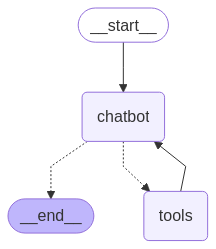

In [26]:
from IPython.display import display, Image

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

# ASK THE CHATBOT!!!

In [28]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({
        "messages": [
            {
                "role": "user",
                "content": user_input
            }
        ]
    }):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

In [30]:
while True:
    try: 
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        
        stream_graph_updates(user_input)
    except:
        user_input = "What do you know about LangChain?"
        print("User: "+ user_input)
        stream_graph_updates(user_input)
        break
    

Assistant: 
Assistant: {"query": "Rayhan Firdaus Ardian", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "Ardian Rayhan Firdaus Profiles - Facebook", "url": "https://www.facebook.com/public/Ardian-Rayhan-Firdaus/", "content": "View the profiles of people named Ardian Rayhan Firdaus. Join Facebook to connect with Ardian Rayhan Firdaus and others you may know. Facebook gives", "score": 0.5809471, "raw_content": null}, {"title": "HappyRehund/DBSCAN-and-KMEANS - GitHub", "url": "https://github.com/HappyRehund/DBSCAN-and-KMEANS", "content": "Machine Learning Assignment - Rayhan Firdaus Ardian / KOMA / 519095 License. MIT license 0 stars 0 forks Branches Tags Activity. Star Notifications You must be signed in to change notification settings. Code; Issues 0; Pull requests 0; Actions; Projects 0; Security. Uh oh!", "score": 0.49436116, "raw_content": null}], "response_time": 2.2}
Assistant: Rayhan Firdaus Ardian adalah seseorang yang mungkin juga dikenal denga